# Artificial Neural Networks and Deep 

## Ex02 - Non-Linearity in Higher Dimensions

In [5]:
import numpy as np

In [6]:
# Parametros da funcao:
meanA = [0,0,0,0,0]
covA = np.array([
    [1.0, 0.8, 0.1, 0.0, 0.0],
    [0.8, 1.0, 0.3, 0.0, 0.0],
    [0.1, 0.3, 1.0, 0.5, 0.0],
    [0.0, 0.0, 0.5, 1.0, 0.2],
    [0.0, 0.0, 0.0, 0.2, 1.0]
])

meanB = [1.5, 1.5, 1.5, 1.5, 1.5]
covB = np.array([
    [1.5, -0.7, 0.2, 0.0, 0.0],
    [-0.7, 1.5, 0.4, 0.0, 0.0],
    [0.2, 0.4, 1.5, 0.6, 0.0],
    [0.0, 0.0, 0.6, 1.5, 0.3],
    [0.0, 0.0, 0.0, 0.3, 1.5]
])

dataA = np.random.multivariate_normal(meanA,covA,500)
dataB = np.random.multivariate_normal(meanB,covB,500)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = np.vstack([dataA, dataB])
y = np.array(['A']*len(dataA) + ['B']*len(dataB))

X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
Z = pca.fit_transform(X_std)


Explained variance ratio (PC1, PC2): [0.52017441 0.15376346]
Total 2D variance explained: 0.6739378707782059


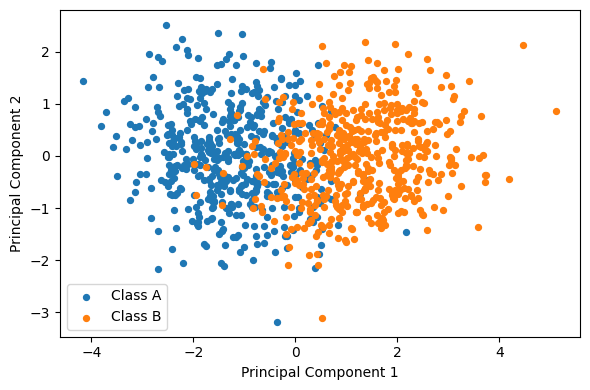

In [7]:
# ---- a partir do seu c√≥digo (dataA, dataB j√° criados) ----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) empilha as duas classes e cria os r√≥tulos
X = np.vstack([dataA, dataB])            # shape (1000, 5)
y = np.array(['A']*len(dataA) + ['B']*len(dataB))

# 2) padroniza (m√©dia 0, desvio 1) antes do PCA
X_std = StandardScaler().fit_transform(X)

# 3) PCA para 2 componentes
pca = PCA(n_components=2)
Z = pca.fit_transform(X_std)             # shape (1000, 2)

# opcional: quanta vari√¢ncia PC1+PC2 explicam?
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total 2D variance explained:", pca.explained_variance_ratio_.sum())

# 4) scatter 2D colorindo por classe
plt.figure(figsize=(6,4))
for lab, col in zip(('A','B'), ('tab:blue','tab:orange')):
    idx = (y == lab)
    plt.scatter(Z[idx, 0], Z[idx, 1], s=18, label=f'Class {lab}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.show()


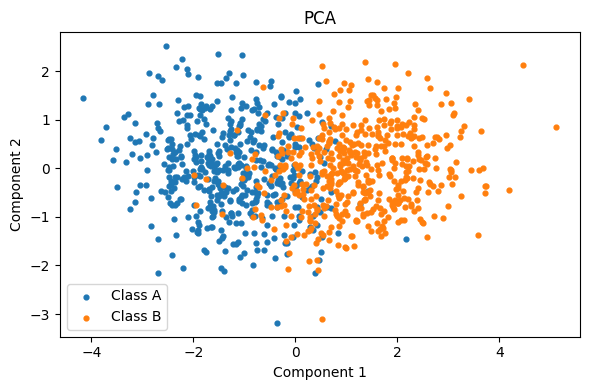

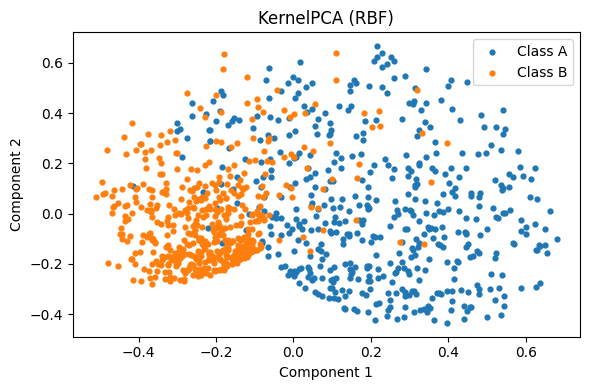

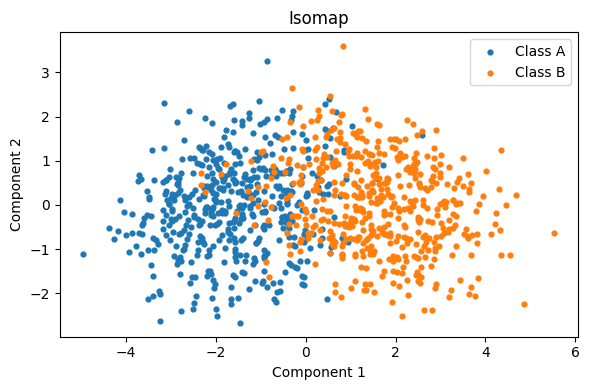

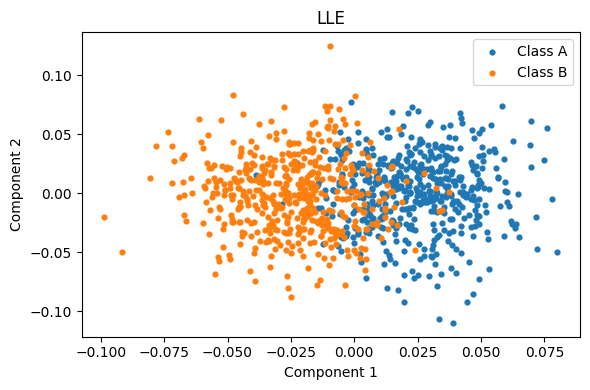

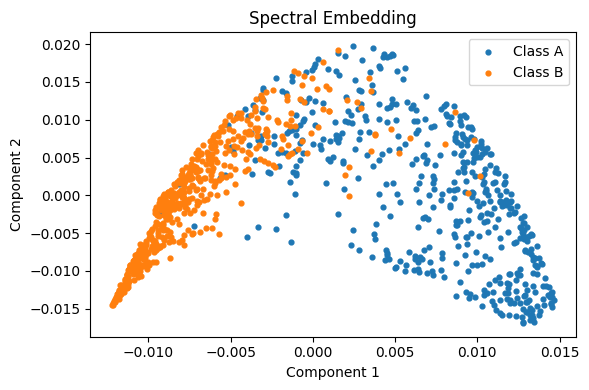

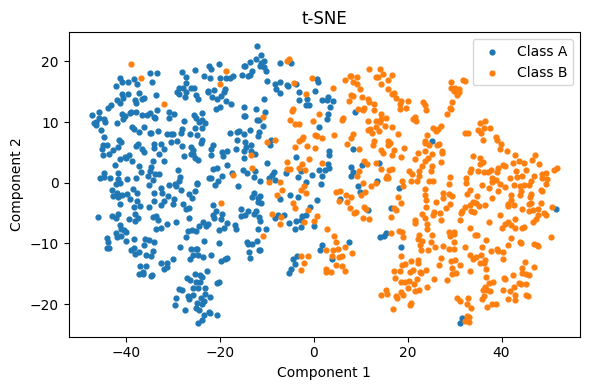


=== Dimensionality Reduction: Comparison Metrics ===
            Method  Trustworthiness@12  Silhouette  kNN(5) CV Acc  Fisher Ratio  Explained Var (2D)
             t-SNE            0.977410    0.461134          0.920      2.826775                 NaN
Spectral Embedding            0.851930    0.352003          0.902      1.062955                 NaN
   KernelPCA (RBF)            0.787827    0.325156          0.892      1.043269                 NaN
               LLE            0.856462    0.274128          0.875      0.839438                 NaN
               PCA            0.864511    0.362713          0.863      1.696896            0.673938
            Isomap            0.868698    0.382801          0.858      1.876618                 NaN


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import silhouette_score

try:
    from sklearn.manifold import trustworthiness
    HAS_TRUST = True
except Exception:
    HAS_TRUST = False
    def trustworthiness(*args, **kwargs):
        return np.nan

X = np.vstack([dataA, dataB])                 # (1000, 5)
y = np.array(['A']*len(dataA) + ['B']*len(dataB))  # (1000,)

# Padroniza√ß√£o (m√©dia 0, desvio 1)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# -----------------------------
# 2) Definir m√©todos (6 no total)
# -----------------------------
methods = {}

# 1) PCA (baseline linear)
methods['PCA'] = PCA(n_components=2)

# 2) Kernel PCA (RBF) para capturar n√£o-linearidade
methods['KernelPCA (RBF)'] = KernelPCA(
    n_components=2, kernel='rbf', gamma=0.5, fit_inverse_transform=False
)

# 3) Isomap (dist√¢ncias geod√©sicas no grafo de vizinhos)
methods['Isomap'] = Isomap(n_components=2, n_neighbors=15)

# 4) LLE (Local Linear Embedding)
methods['LLE'] = LocallyLinearEmbedding(
    n_neighbors=15, n_components=2, method='standard'
)

# 5) Spectral Embedding (Laplacian Eigenmaps)
methods['Spectral Embedding'] = SpectralEmbedding(
    n_components=2, n_neighbors=15, random_state=42
)

# 6) t-SNE (boa separa√ß√£o local para visualiza√ß√£o)
methods['t-SNE'] = TSNE(
    n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42
)

# -----------------------------
# 3) Fun√ß√µes auxiliares
# -----------------------------
def run_embedding(model, X_input):
    """Aplica fit_transform quando existir; sen√£o fit + transform."""
    if hasattr(model, 'fit_transform'):
        Z = model.fit_transform(X_input)
    else:
        model.fit(X_input)
        Z = model.transform(X_input)
    return Z

def plot_embedding(Z, title, y):
    """Scatter 2D com as duas classes (sem definir cores explicitamente)."""
    plt.figure(figsize=(6, 4))
    idxA = (y == 'A')
    idxB = ~idxA
    plt.scatter(Z[idxA, 0], Z[idxA, 1], s=12, label='Class A')
    plt.scatter(Z[idxB, 0], Z[idxB, 1], s=12, label='Class B')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

def fisher_separation(Z, y):
    """
    Medida simples tipo Fisher para 2 classes:
    ||muA - muB||^2 / trace(Sw),
    onde Sw = cov(ZA) + cov(ZB)
    """
    ZA = Z[y == 'A']
    ZB = Z[y == 'B']
    muA = ZA.mean(axis=0)
    muB = ZB.mean(axis=0)
    Sw = np.cov(ZA, rowvar=False) + np.cov(ZB, rowvar=False)
    num = np.sum((muA - muB)**2)
    den = np.trace(Sw)
    return float(num / den) if den > 0 else np.nan

def knn_cv_accuracy(Z, y, n_splits=5, n_neighbors=5):
    """Acur√°cia m√©dia 5-fold CV de um k-NN (k=5) no embedding 2D."""
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(clf, Z, y, cv=cv, scoring='accuracy')
    return float(scores.mean())

# -----------------------------
# 4) Rodar m√©todos + coletar m√©tricas
# -----------------------------
rows = []

if not HAS_TRUST:
    print("[aviso] sklearn.manifold.trustworthiness n√£o dispon√≠vel nesta vers√£o; m√©tricas 'Trustworthiness' ser√£o NaN.\n")

for name, model in methods.items():
    Z = run_embedding(model, X_std)

    # Plota (figura separada por m√©todo)
    plot_embedding(Z, f'{name}', y)

    # M√©tricas
    tw = trustworthiness(X_std, Z, n_neighbors=12)
    sil = silhouette_score(Z, y)        # separa√ß√£o das classes no 2D
    acc = knn_cv_accuracy(Z, y, n_splits=5, n_neighbors=5)
    fish = fisher_separation(Z, y)

    # PCA: vari√¢ncia explicada em 2D
    if name == 'PCA':
        pca_var2d = float(np.sum(methods['PCA'].explained_variance_ratio_))
    else:
        pca_var2d = np.nan

    rows.append({
        'Method': name,
        'Trustworthiness@12': tw,
        'Silhouette': sil,
        'kNN(5) CV Acc': acc,
        'Fisher Ratio': fish,
        'Explained Var (2D)': pca_var2d
    })

# -----------------------------
# 5) Mostrar tabela de m√©tricas
# -----------------------------
df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics.sort_values(
    by=['kNN(5) CV Acc', 'Silhouette', 'Trustworthiness@12'],
    ascending=False
).reset_index(drop=True)

print("\n=== Dimensionality Reduction: Comparison Metrics ===")
print(df_metrics.to_string(index=False))

1) O que os gr√°ficos mostram sobre a rela√ß√£o entre as classes

PCA (linear, vari√¢ncia global)

As duas classes se deslocam principalmente ao longo do 1¬∫ componente (PC1).

H√° sobreposi√ß√£o consider√°vel na regi√£o central: as ‚Äúcaudas‚Äù el√≠pticas dos dois grupos se interpenetram.

Leitura: existe um shift de m√©dia entre A e B (esperado, pois ¬µ_B = 1.5 em todas as dimens√µes), mas as covari√¢ncias diferentes (orienta√ß√µes/formatos dos elips√≥ides) fazem os pontos ‚Äúmisturarem‚Äù quando projetados em 2D.

Kernel PCA (RBF)

Aparece um fronteira curva (formato ‚Äúbanana‚Äù) entre os grupos.

O m√©todo est√° captando estruturas n√£o‚Äëlineares que o PCA linear n√£o mostra. A separa√ß√£o melhora em rela√ß√£o ao PCA, mas ainda h√° zona de transi√ß√£o.

Isomap

Proje√ß√£o lembra o PCA (classes separadas grosso modo ao longo de um eixo), mas com distor√ß√µes que alongam a nuvem.

Ainda existe faixa de sobreposi√ß√£o: um √∫nico hiperplano n√£o separa perfeitamente.

LLE

Resultado muito parecido com o PCA: tend√™ncia linear + mistura no meio.

Indica que a estrutura local n√£o oferece uma divis√£o limpa sem curvatura adicional.

Spectral Embedding

Surge uma estrutura em arco/horseshoe. As classes ocupam metades do arco, com bordas que se entremeiam.

A fronteira √© claramente n√£o‚Äëlinear.

t‚ÄëSNE

Dois aglomerados bem separados no plano 2D; quase n√£o h√° mistura visual.

Cuidado: t‚ÄëSNE preserva vizinhan√ßas locais, mas n√£o preserva dist√¢ncias/forma globais. Essa separa√ß√£o ‚Äúbonita‚Äù n√£o garante que exista um corte linear no espa√ßo original; ela mostra, por√©m, que localmente as vizinhan√ßas de A e B s√£o diferentes.

Resumo da rela√ß√£o entre as classes:

H√° um deslocamento de m√©dia entre A e B + diferen√ßas de correla√ß√£o/orienta√ß√£o (covari√¢ncias distintas).

Em proje√ß√µes lineares (PCA/LLE/Isomap) a separa√ß√£o √© parcial; em proje√ß√µes n√£o‚Äëlineares (KernelPCA, Spectral, t‚ÄëSNE) aparece uma borda curva e a separa√ß√£o melhora.

2) As classes s√£o linearmente separ√°veis?

N√£o perfeitamente.

Nos m√©todos lineares (PCA, LLE) h√° uma faixa de interpenetra√ß√£o clara.

Mesmo quando a visualiza√ß√£o sugere separa√ß√£o (t‚ÄëSNE), isso n√£o implica uma hiperplano no 5D original.

Por que isso acontece aqui?

As matrizes de covari√¢ncia n√£o s√£o iguais: 
Œ£
ùê¥
‚â†
Œ£
ùêµ
Œ£
A
	‚Äã

ÓÄ†
=Œ£
B
	‚Äã

.

Para duas gaussianas com covari√¢ncias iguais, a fronteira √≥tima (via raz√£o de verossimilhan√ßa) √© linear (caso LDA).

Quando as covari√¢ncias diferem, a fronteira Bayes √≥tima vira quadr√°tica (caso QDA) ‚Äî n√£o linear.

√â exatamente o seu cen√°rio: A tem correla√ß√µes fortes (e.g., 0.8 entre 
ùë•
1
,
ùë•
2
x
1
	‚Äã

,x
2
	‚Äã

, 0.5 entre 
ùë•
3
,
ùë•
4
x
3
	‚Äã

,x
4
	‚Äã

), B tem outras correla√ß√µes (e.g., ‚Äë0.7 entre 
ùë•
1
,
ùë•
2
x
1
	‚Äã

,x
2
	‚Äã

, 0.6 entre 
ùë•
3
,
ùë•
4
x
3
	‚Äã

,x
4
	‚Äã

). Esses ‚Äúgiros/alongamentos‚Äù el√≠pticos diferentes fazem as nuvens se cruzarem; um hiperplano n√£o consegue separar sem erro.

3) Por que modelos lineares simples sofrem ‚Äî e por que redes com n√£o‚Äëlinearidades ajudam

Modelos lineares (Perceptron, Regress√£o Log√≠stica sem features n√£o‚Äëlineares) s√≥ implementam uma √∫nica fronteira plana.

Como as classes aqui precisam de uma fronteira curvada (quadr√°tica ou mais complexa) para reduzir a faixa de sobreposi√ß√£o, um hiperplano vai sempre cortar a zona mista e errar bastante.

Modelos com n√£o‚Äëlinearidade (multi‚Äëlayer perceptron com ReLU/tanh, kernel methods, QDA, SVM com kernel RBF) conseguem ‚Äúentortar‚Äù o espa√ßo ou compor curvas para aproximar a fronteira Bayesiana.

A evid√™ncia visual: Kernel PCA, Spectral e t‚ÄëSNE revelam uma separa√ß√£o curvada/manifold‚Äëlike, sugerindo que duas ou mais regi√µes precisam ser recortadas por uma fun√ß√£o n√£o‚Äëlinear para dividir A e B com boa acur√°cia.

4) Como eu justificaria no relat√≥rio (em 4 frases)

As proje√ß√µes mostram que A e B diferem principalmente ao longo de um eixo global (PC1), mas se sobrep√µem de forma relevante.

M√©todos n√£o‚Äëlineares (KernelPCA, Spectral, t‚ÄëSNE) revelam fronteiras curvas e melhor separa√ß√£o local, o que n√£o aparece na proje√ß√£o linear.

Como 
Œ£
ùê¥
‚â†
Œ£
ùêµ
Œ£
A
	‚Äã

ÓÄ†
=Œ£
B
	‚Äã

, a fronteira √≥tima entre as distribui√ß√µes gaussianas √© quadr√°tica, logo n√£o linear; um hiperplano n√£o separa bem.

Portanto, modelos lineares tendem a ter erro alto, enquanto modelos com n√£o‚Äëlinearidades (ex.: MLP com tanh/ReLU, SVM RBF ou QDA) s√£o mais adequados para capturar a geometria curvada do problema.

Se quiser, posso olhar as m√©tricas que voc√™ imprimiu (silhouette, kNN‚Äëacc, trustworthiness) e escrever duas linhas conectando cada m√©todo aos n√∫meros que voc√™ obteve ‚Äî isso deixa sua an√°lise redonda.